# Calculation of SASA (Solvent accessible surface area) for pdb files
Created 2025-05-06 by Andreas

In [3]:
import datetime
import math
import numpy as np
import pathlib
import pandas as pd
import sys
import time
import logging
from io import StringIO
from multiprocessing import Pool, cpu_count, get_logger
import multiprocessing_logging
multiprocessing_logging.install_mp_handler()
from typing import Self

import freesasa
import biotite.structure as struc
import biotite.structure.io.pdb as bt_pdb
from Bio.PDB import PDBParser
from Bio.PDB.Structure import Structure as BioPy_PDBStructure
from Bio.PDB.Model import Model as BioPy_PDBModel
from Bio.PDB.PDBExceptions import PDBConstructionException
parser = PDBParser(QUIET=True)

LOGLEVEL_ADDITIONAL_INFO = 19 # The module logs more information like for example the current processed file with this level

logger = logging.getLogger("measure_PPI")
formatter = logging.Formatter(fmt="[%(asctime)s | %(module)s | %(levelname)s] %(message)s")
streamHandler = logging.StreamHandler(sys.stdout)
streamHandler.setFormatter(formatter)
logger.setLevel(logging.INFO)
logger.addHandler(streamHandler)
logging.addLevelName(LOGLEVEL_ADDITIONAL_INFO, "INFO")

In [4]:
def OpenStructure(path: pathlib.Path, structure_name: str = "") -> tuple[BioPy_PDBStructure|None, struc.AtomArray|None]:
    """
        Opens the given structure and returns the Bio.PDB and biotite objects.
    """
    t0 = time.perf_counter()
    file_name = path.name
    try:
        structure_biopy = parser.get_structure("structure", file=path)
        structure_biotite = bt_pdb.get_structure(bt_pdb.PDBFile.read(path))
    except PDBConstructionException:
        logger.warning(f"Can't parse structure {structure_name} (file {file_name}) using Biopython")
        return (None, None)
    except ValueError as ex:
        logger.warning(f"Can't parse structure {structure_name} (file {file_name}) due to the following reason: {ex}")
        return (None, None)
    
    if structure_biotite.stack_depth() != 1:
        logger.warning(f"Can't parse structure {structure_name} (file {file_name}) because it contains more than one stack")
        return (None, None)
    
    atomarray_biotite: struc.AtomArray = structure_biotite[0]

    chains = [c for c in structure_biopy.get_chains()]
    if len(chains) != 2:
        logger.warning(f"Can't parse structure {structure_name} (file {file_name}) because it has not 2 chains")
        return (None, None)
    
    t1 = time.perf_counter()
    logger.debug(f"Runtime reading structure {structure_name} (file {file_name}): {round((t1-t0)*1000, 1)}ms")
    return (structure_biopy, atomarray_biotite)

In [21]:
structure_path = pathlib.Path(r"D:\Eigene Datein\dev\Uni\JGU Bio Bachelorthesis\Daten\resources\AF2\DMI\known_DMI\DEG_APCC_KENBOX_2_4GGD\ranked_0.pdb")
structure_biopy, atomarray_biotite = OpenStructure(structure_path)

In [ ]:
# STOP Cell
raise Exception("STOP")

In [5]:
def calculate_buried_area(structure_biopy:BioPy_PDBStructure):
    """
        Calculates the buried surface area using freesasa which is defined as surface area of the two chains
        subtracted from the surface area of the complex.
    """
    ti = time.perf_counter()
    chains = [c for c in structure_biopy.get_chains()]
    assert len(chains) == 2

    chain1 = structure_biopy[0][chains[0].id]
    chain2 = structure_biopy[0][chains[1].id]

    strucChain1 = BioPy_PDBStructure('structure')
    modelChain1 = BioPy_PDBModel("1")
    modelChain1.add(chain1)
    strucChain1.add(modelChain1)
    strucChain2 = BioPy_PDBStructure('structure')
    modelChain2 = BioPy_PDBModel("1")
    modelChain2.add(chain2)
    strucChain2.add(modelChain2)
    t1 = time.perf_counter()

    fs_pp = freesasa.structureFromBioPDB(structure_biopy)
    fs_chain1 = freesasa.structureFromBioPDB(strucChain1)
    fs_chain2 = freesasa.structureFromBioPDB(strucChain2)
    t2 = time.perf_counter()

    area_pp = freesasa.calc(fs_pp).totalArea()
    area_chain1 = freesasa.calc(fs_chain1).totalArea()
    area_chain2 = freesasa.calc(fs_chain2).totalArea()
    tf = time.perf_counter()

    buried_area = (area_chain1 + area_chain2 - area_pp)
    tf = time.perf_counter()
    logger.debug(f"Sasa values: Chain 1 = {round(area_chain1, 3)}, Chain 2 = {round(area_chain2, 3)}, Total = {round(area_pp, 3)}")
    logger.debug(f"Runtime calculate_buried_area: {round((tf-ti)*1000, 1)}ms ({round((t1-ti)*1000, 1)}ms model buiilding, {round((t2-t1)*1000, 1)}ms loading, {round((tf-t2)*1000, 1)}ms sasa calc)")
    return round(buried_area, 3)


In [7]:
calculate_buried_area(structure_biopy)

613.651

### Snippet to calculate SASA for a given subset of a structure

In [58]:
import freesasa
from pathlib import Path
from Bio.PDB import PDBParser
from Bio.PDB.Structure import Structure as BioPy_PDBStructure
from Bio.PDB.Model import Model as BioPy_PDBModel
from Bio.PDB.PDBExceptions import PDBConstructionException
parser = PDBParser(QUIET=True)

def open_structure(path: Path) -> BioPy_PDBStructure:
    return parser.get_structure("structure", file=path)


structure_biopy = open_structure(Path(r"D:\Eigene Datein\dev\Uni\JGU Bio Bachelorthesis\Daten\resources\AF2\DMI\known_DMI\DEG_APCC_KENBOX_2_4GGD\ranked_0.pdb"))

chains = [c for c in structure_biopy.get_chains()]

chain1 = structure_biopy[0][chains[0].id]

# Whole pdb structure
fs_pp = freesasa.structureFromBioPDB(structure_biopy)

# Only Chain 1
# For this, create a virtual PDB structure and add chain 1 to it
strucChain1 = BioPy_PDBStructure('structure') # create empty PDB structure
modelChain1 = BioPy_PDBModel("1") # create empty model (id 1)
modelChain1.add(chain1) # add chain 1 to model 1
strucChain1.add(modelChain1) # add model 1 to structure
fs_chain1 = freesasa.structureFromBioPDB(strucChain1) # FreeSasa structure object

for res_id, res_sasa in freesasa.calc(fs_chain1).residueAreas()[chain1.id].items():
    print(f"{res_id:>4} {chain1[int(res_id)].resname}: {res_sasa.total:9.3f} Å²")

   1 CYS:   185.055 Å²
   2 ARG:    34.129 Å²
   3 TYR:   177.533 Å²
   4 ILE:    29.491 Å²
   5 PRO:    39.409 Å²
   6 SER:    75.548 Å²
   7 LEU:   131.537 Å²
   8 PRO:    23.531 Å²
   9 ASP:    90.196 Å²
  10 ARG:   107.767 Å²
  11 ILE:    87.803 Å²
  12 LEU:    31.495 Å²
  13 ASP:   122.202 Å²
  14 ALA:     0.134 Å²
  15 PRO:    70.950 Å²
  16 GLU:   114.033 Å²
  17 ILE:     9.538 Å²
  18 ARG:    92.201 Å²
  19 ASN:    90.760 Å²
  20 ASP:    32.335 Å²
  21 TYR:    12.114 Å²
  22 TYR:    58.840 Å²
  23 LEU:     0.931 Å²
  24 ASN:    21.790 Å²
  25 LEU:     3.851 Å²
  26 VAL:     7.234 Å²
  27 ASP:    25.578 Å²
  28 TRP:    22.400 Å²
  29 SER:     3.965 Å²
  30 SER:    63.697 Å²
  31 GLY:    52.429 Å²
  32 ASN:    41.046 Å²
  33 VAL:    33.196 Å²
  34 LEU:     0.010 Å²
  35 ALA:     0.000 Å²
  36 VAL:     5.968 Å²
  37 ALA:     0.385 Å²
  38 LEU:    16.520 Å²
  39 ASP:    36.878 Å²
  40 ASN:    41.128 Å²
  41 SER:     4.905 Å²
  42 VAL:     0.000 Å²
  43 TYR:    68.471 Å²
  44 LEU:  

### Comparing different SASA algorithms

In [ ]:
a = [r for r in structure_biopy[0].get_atoms()][12]

a.

('structure', 0, 'A', (' ', 1, ' '), ('HG', ' '))

In [129]:
from rust_sasa_python import calculate_sasa_at_atom_level, calculate_sasa_at_residue_level, calculate_sasa_at_protein_level
from Bio.PDB.SASA import ShrakeRupley
from biotite.structure import sasa

d = []
for a in structure_biopy[0].get_atoms():
    d.append({
        "Chain": a.parent.parent.id,
        "Res_ID": a.parent.id[1],
        "Residue": a.parent.resname,
        "Atom": a.id,
        "Element": a.element
    })
df_a = pd.DataFrame(d)
d = []
for a in structure_biopy[0].get_residues():
    d.append({
        "Chain": a.parent.id,
        "Res_ID": a.id[1],
        "Residue": a.resname,
    })
df_r = pd.DataFrame(d)

for i, a in enumerate(atomarray_biotite):
    if a.atom_name != df_a.loc[i]["Atom"] or a.res_id != df_a.loc[i]["Res_ID"]:
        raise RuntimeError("Biotite and Biopython have a different order of the atoms")


# Biopython
t_biopy= time.perf_counter()
sr = ShrakeRupley()
sr.compute(structure_biopy, level="R")
df_r["biopython"] = [r.sasa for r in structure_biopy[0].get_residues()]
t_biopy_r = time.perf_counter()

sr = ShrakeRupley()
sr.compute(structure_biopy, level="A")
df_a["biopython"] = [a.sasa for a in structure_biopy[0].get_atoms()]
t_biopy_a = time.perf_counter()

sr = ShrakeRupley()
sr.compute(structure_biopy, level="M")
biopy_sum = structure_biopy[0].sasa
t_biopy_t = time.perf_counter()

biopy_sum_a = np.nansum(df_a["biopython"])
biopy_sum_r = np.nansum(df_r["biopython"])
print("Biopython SASA")
print(f" sum by atoms: {biopy_sum_a:1.3f} Å²")
print(f" sum by res. : {biopy_sum_r:1.3f} Å²")
print(f" (total)     : {biopy_sum:1.3f} Å²")


# Biotite
t_biotite = time.perf_counter()
biotite_sasa = sasa(atomarray_biotite)
df_a["biotite"] = biotite_sasa
t_biotite_a = time.perf_counter()

df_r["biotite"] = [np.nansum(biotite_sasa[(atomarray_biotite.res_id == df_r_row["Res_ID"]) & (atomarray_biotite.chain_id == df_r_row["Chain"])])  for i, df_r_row in df_r.iterrows()]

biotite_sum_a = np.nansum(biotite_sasa)

print("Biotite SASA")
print(f" sum by atoms: {biotite_sum_a:1.3f} Å²")


# Rust SASA
t_rust_sasa = time.perf_counter()
df_r["rust_sasa"] = [x[1] for x in calculate_sasa_at_residue_level(str(structure_path))]
t_rust_sasa_r = time.perf_counter()

df_a["rust_sasa"] = calculate_sasa_at_atom_level(str(structure_path))
t_rust_sasa_a = time.perf_counter()

rust_sasa_sum = calculate_sasa_at_protein_level(str(structure_path))[0]
t_rust_sasa_t = time.perf_counter()

rust_sasa_sum_r = np.nansum(df_r["rust_sasa"])
rust_sasa_sum_a = np.nansum(df_a["rust_sasa"])

print("rust-sasa")
print(f" sum by atoms: {rust_sasa_sum_a:1.3f} Å²")
print(f" sum by res. : {rust_sasa_sum_r:1.3f} Å²")
print(f" (total)     : {rust_sasa_sum:1.3f} Å²")


# Freesasa Lee-Richard
t_freesasa = time.perf_counter()
fs_structure = freesasa.structureFromBioPDB(structure_biopy)
fs_result = freesasa.calc(fs_structure)
df_r["freesasa_lr"] = [res_area.total for chain_id,res_dict in fs_result.residueAreas().items() for res_id, res_area in res_dict.items()]
t_freesasa_r = time.perf_counter()

fs_structure = freesasa.structureFromBioPDB(structure_biopy)
fs_result = freesasa.calc(fs_structure)
n = -1
df_a["freesasa_lr"] = [fs_result.atomArea((n := n + 1)) if df_a.loc[i]["Element"] != "H" else np.nan for i in range(len(df_a))]
t_freesasa_a = time.perf_counter()

fs_structure = freesasa.structureFromBioPDB(structure_biopy)
fs_result = freesasa.calc(fs_structure)
fs_sasa_sum = fs_result.totalArea()
t_freesasa_t = time.perf_counter()

fs_sasa_sum_r = np.nansum(df_r["freesasa_lr"])
fs_sasa_sum_a = np.nansum(df_a["freesasa_lr"])
print("freesasa_lr")
print(f" sum by atoms: {fs_sasa_sum_a:1.3f} Å²")
print(f" sum by res. : {fs_sasa_sum_r:1.3f} Å²")
print(f" (total)     : {fs_sasa_sum:1.3f} Å²")


# Freesasa Shake-Rupley
t_freesasa2 = time.perf_counter()
fs_structure = freesasa.structureFromBioPDB(structure_biopy)
fs_result = freesasa.calc(fs_structure, freesasa.Parameters({'algorithm' : freesasa.ShrakeRupley}))
df_r["freesasa_sr"] = [res_area.total for chain_id,res_dict in fs_result.residueAreas().items() for res_id, res_area in res_dict.items()]
t_freesasa2_r = time.perf_counter()

fs_structure = freesasa.structureFromBioPDB(structure_biopy)
fs_result = freesasa.calc(fs_structure, freesasa.Parameters({'algorithm' : freesasa.ShrakeRupley}))
n = -1
df_a["freesasa_sr"] = [fs_result.atomArea((n := n + 1)) if df_a.loc[i]["Element"] != "H" else np.nan for i in range(len(df_a))]
t_freesasa2_a = time.perf_counter()

fs_structure = freesasa.structureFromBioPDB(structure_biopy)
fs_result = freesasa.calc(fs_structure, freesasa.Parameters({'algorithm' : freesasa.ShrakeRupley}))
fs_sasa_sum = fs_result.totalArea()
t_freesasa2_t = time.perf_counter()

fs_sasa_sum_r = np.nansum(df_r["freesasa_sr"])
fs_sasa_sum_a = np.nansum(df_a["freesasa_sr"])
print("freesasa_sr")
print(f" sum by atoms: {fs_sasa_sum_a:1.3f} Å²")
print(f" sum by res. : {fs_sasa_sum_r:1.3f} Å²")
print(f" (total)     : {fs_sasa_sum:1.3f} Å²")


display(df_a)
display(df_r)

print("Protein level")
print(f" biopython: {1000*(t_biopy_t - t_biopy_a):1.3f} ms")
print(f" biotite: -")
print(f" rust_sasa: {1000*(t_rust_sasa_t - t_rust_sasa_a):1.3f} ms")
print(f" freesasa_lr: {1000*(t_freesasa_t - t_freesasa_a):1.3f} ms")
print(f" freesasa_sr: {1000*(t_freesasa2_t - t_freesasa2_a):1.3f} ms")
print("Residue level")
print(f" biopython: {1000*(t_biopy_r - t_biopy):1.3f} ms")
print(f" biotite: -")
print(f" rust_sasa: {1000*(t_rust_sasa_r - t_rust_sasa):1.3f} ms")
print(f" freesasa_lr: {1000*(t_freesasa_r - t_freesasa):1.3f} ms")
print(f" freesasa_sr: {1000*(t_freesasa2_r - t_freesasa2):1.3f} ms")
print("Atom level")
print(f" biopython: {1000*(t_biopy_a - t_biopy_r):1.3f} ms")
print(f" biotite: {1000*(t_biotite_a - t_biotite):1.3f} ms")
print(f" rust_sasa: {1000*(t_rust_sasa_a - t_rust_sasa_r):1.3f} ms")
print(f" rust_sasa: {1000*(t_freesasa_a - t_freesasa_r):1.3f} ms")
print(f" freesasa_sr: {1000*(t_freesasa2_a - t_freesasa2_r):1.3f} ms")




Biopython SASA
 sum by atoms: 12868.778 Å²
 sum by res. : 12868.778 Å²
 (total)     : 12868.778 Å²
Biotite SASA
 sum by atoms: 12889.402 Å²
rust-sasa
 sum by atoms: 12862.722 Å²
 sum by res. : 12800.909 Å²
 (total)     : 12862.725 Å²
freesasa_lr
 sum by atoms: 12875.797 Å²
 sum by res. : 12875.797 Å²
 (total)     : 12875.797 Å²
freesasa_sr
 sum by atoms: 12897.894 Å²
 sum by res. : 12897.894 Å²
 (total)     : 12897.894 Å²


,Chain,Res_ID,Residue,Atom,Element,biopython,biotite,rust_sasa,freesasa_lr,freesasa_sr
0,A,1,CYS,N,N,1.093588,46.569485,9.413318,46.849519,44.130681
1,A,1,CYS,H,H,16.140246,NaN,15.290759,NaN,NaN
2,A,1,CYS,H2,H,24.635113,NaN,20.387678,NaN,NaN
3,A,1,CYS,H3,H,18.688706,NaN,14.441272,NaN,NaN
4,A,1,CYS,CA,C,0.000000,12.167463,0.000000,12.186268,12.167464
...,...,...,...,...,...,...,...,...,...,...
4814,B,5,VAL,CG2,C,0.000000,25.146091,2.525564,24.109920,25.686868
4815,B,5,VAL,HG21,H,0.849487,NaN,0.849487,NaN,NaN
4816,B,5,VAL,HG22,H,14.441273,NaN,15.290759,NaN,NaN
4817,B,5,VAL,HG23,H,9.344353,NaN,7.645380,NaN,NaN


,Chain,Res_ID,Residue,biopython,biotite,rust_sasa,freesasa_lr,freesasa_sr
0,A,1,CYS,203.037426,183.870361,85.123825,185.055281,180.968856
1,A,2,ARG,33.777650,32.885609,126.009727,34.128721,33.686971
2,A,3,TYR,189.763405,178.421753,0.000000,177.532551,179.619404
3,A,4,ILE,28.775782,29.587866,42.618572,29.491268,31.802719
4,A,5,PRO,31.655944,39.588451,161.165268,39.408599,37.501719
...,...,...,...,...,...,...,...,...
312,B,1,SER,90.175723,82.422760,85.123825,82.510811,83.890451
313,B,2,LYS,121.600622,121.189995,126.009727,120.410264,117.145064
314,B,3,GLU,1.071459,1.099261,0.000000,0.952339,0.999328
315,B,4,ASN,44.424684,43.253330,42.618572,43.401231,44.647485


Protein level
 biopython: 810.117 ms
 biotite: -
 rust_sasa: 36.221 ms
 freesasa_lr: 60.967 ms
 freesasa_sr: 24.095 ms
Residue level
 biopython: 854.134 ms
 biotite: -
 rust_sasa: 36.397 ms
 freesasa_lr: 60.820 ms
 freesasa_sr: 23.390 ms
Atom level
 biopython: 812.548 ms
 biotite: 94.425 ms
 rust_sasa: 37.241 ms
 rust_sasa: 151.465 ms
 freesasa_sr: 114.878 ms


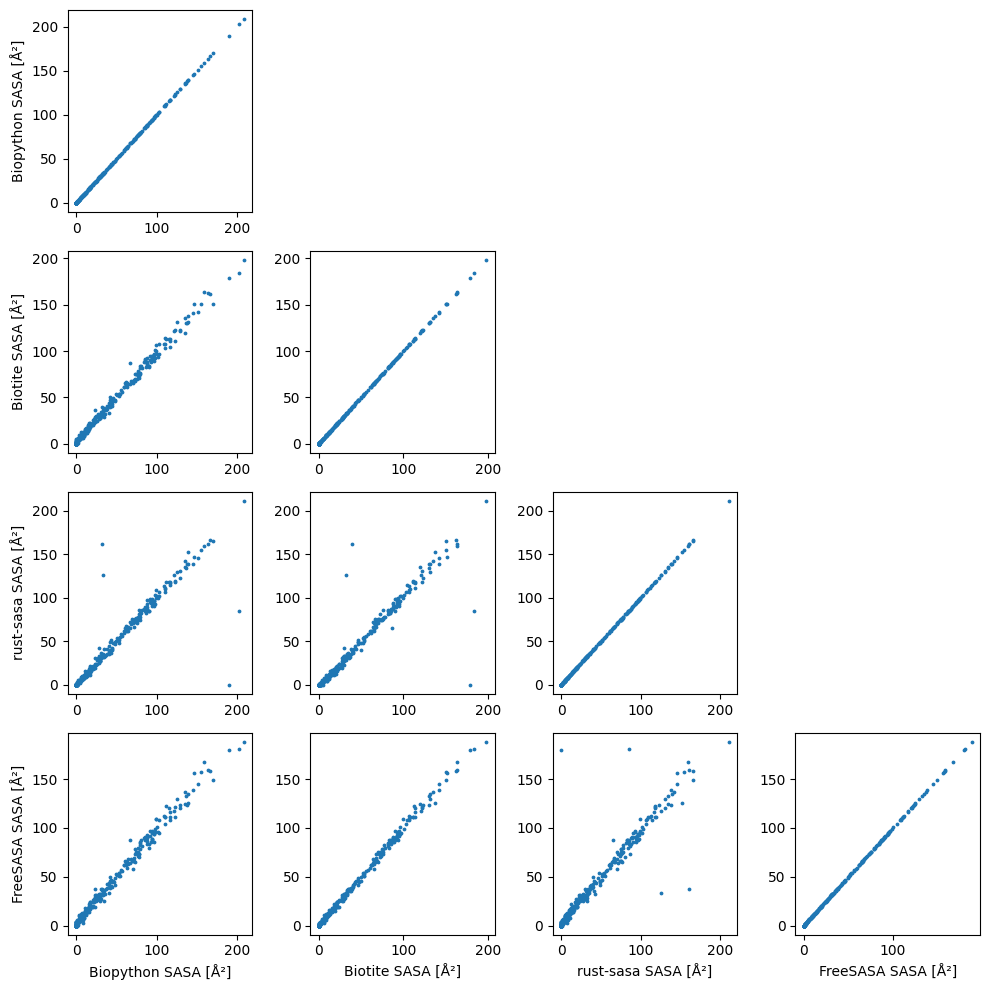

In [147]:
# Plotting
import matplotlib.pyplot as plt

algos = {"biopython": "Biopython", "biotite": "Biotite", "rust_sasa": "rust-sasa", "freesasa_sr": "FreeSASA"}

fig, axes = plt.subplots(4, 4, figsize=(10,10))

for y in range(4):
    for x in range(y+1,4):
        axes[y,x].set_visible(False)

for y, (algo1, algo1_lbl) in enumerate(algos.items()):
    axes[y, 0].set_ylabel(f"{algo1_lbl} SASA [Å²]")
    for x, (algo2, algo2_lbl) in enumerate(algos.items()):
        axes[y,x].scatter(df_r[algo2], df_r[algo1], s=3)
        axes[3,x].set_xlabel(f"{algo2_lbl} SASA [Å²]")

plt.tight_layout()
fig.savefig("export.png", dpi=600)
plt.show()